In [1]:
import os
import csv
import datetime
import pandas as pd
from models.fir_regression import FIR_Regression
from models.support_vector_regression_with_RBF import SVR_RBF
from utils.loader import load_data_with_logReturn
from utils.device import get_best_device

In [2]:
class BacktestRunner:
    def __init__(self, model_class, model_config):
        self.model_class = model_class
        self.model_config = model_config
        self.model = model_class(**model_config)
        self.best_model = None
        self.eval_result = None
        self.sim_result = None
        self.sim_fig = None

    def train_optimal_model(self):
        self.model.train()
        self.best_model = self.model
        return self.best_model

    def evaluate_model(self):
        self.eval_result = self.model.evaluate()
        return self.eval_result

    def run_real_world_simulation(self, sim_class, sim_config):
        sim = sim_class(model=self.best_model.model,
                        scaler=self.model.scaler,
                        **sim_config)
        self.sim_result, self.sim_fig = sim.run_simulation()
        return self.sim_result, self.sim_fig

    def log_results(self, log_root="log", log_name=None):
        if self.eval_result is None or self.sim_result is None:
            raise ValueError("Must run evaluate_model and run_real_world_simulation before logging.")

        if log_name is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            log_name = f"log_{timestamp}"

        model_name = self.model_class.__name__
        log_dir = os.path.join(log_root, model_name)
        fig_dir = os.path.join(log_dir, "figs")
        os.makedirs(log_dir, exist_ok=True)
        os.makedirs(fig_dir, exist_ok=True)

        csv_path = os.path.join(log_dir, f"{log_name}.csv")

        # Unified config handling
        config_to_log = self.model_config["config"] if "config" in self.model_config else self.model_config.copy()
        config_to_log = config_to_log.copy()
        config_to_log["device"] = str(config_to_log.get("device", ""))

        log_entry = {
            "train_val_start": self.model_config["train_val_test_start"],
            "train_val_end": self.model_config["train_val_test_end"],
            "test_start": self.model_config["train_val_test_start"],
            "test_end": self.model_config["train_val_test_end"],
            **self.eval_result,
            **self.sim_result,
            **config_to_log
        }

        file_exists = os.path.isfile(csv_path)
        with open(csv_path, mode="a", newline="") as f:
            writer = csv.DictWriter(f, fieldnames=log_entry.keys())
            if not file_exists:
                writer.writeheader()
            writer.writerow(log_entry)

        # Save figure if available
        if hasattr(self, "sim_fig") and self.sim_fig is not None:
            fig_path = os.path.join(fig_dir, f"{log_name}.png")
            self.sim_fig.savefig(fig_path)
            print(f"[INFO] Saved figure to {fig_path}")


In [3]:
device = get_best_device()

## MLP

In [8]:
from models.mlp import MLP_Regression, MLP_Simulation

[INFO] Running experiment from 1990-01-01 to 2005-04-30...
Epoch 01 | Train Loss: 0.001195 | Val Loss: 0.001994
Epoch 02 | Train Loss: 0.000975 | Val Loss: 0.001977
Epoch 03 | Train Loss: 0.000754 | Val Loss: 0.001478
Epoch 04 | Train Loss: 0.000574 | Val Loss: 0.001255
Epoch 05 | Train Loss: 0.000644 | Val Loss: 0.001373
Epoch 06 | Train Loss: 0.000757 | Val Loss: 0.001662
Epoch 07 | Train Loss: 0.000484 | Val Loss: 0.001874
Epoch 08 | Train Loss: 0.000531 | Val Loss: 0.001863
Epoch 09 | Train Loss: 0.000503 | Val Loss: 0.001617
Epoch 10 | Train Loss: 0.000471 | Val Loss: 0.001488
Epoch 11 | Train Loss: 0.000342 | Val Loss: 0.001452
Epoch 12 | Train Loss: 0.000349 | Val Loss: 0.001484
Epoch 13 | Train Loss: 0.000413 | Val Loss: 0.001545
Epoch 14 | Train Loss: 0.000448 | Val Loss: 0.001582
Epoch 15 | Train Loss: 0.000335 | Val Loss: 0.001586
Epoch 16 | Train Loss: 0.000197 | Val Loss: 0.001581
Epoch 17 | Train Loss: 0.000283 | Val Loss: 0.001615
Epoch 18 | Train Loss: 0.000286 | Val Lo

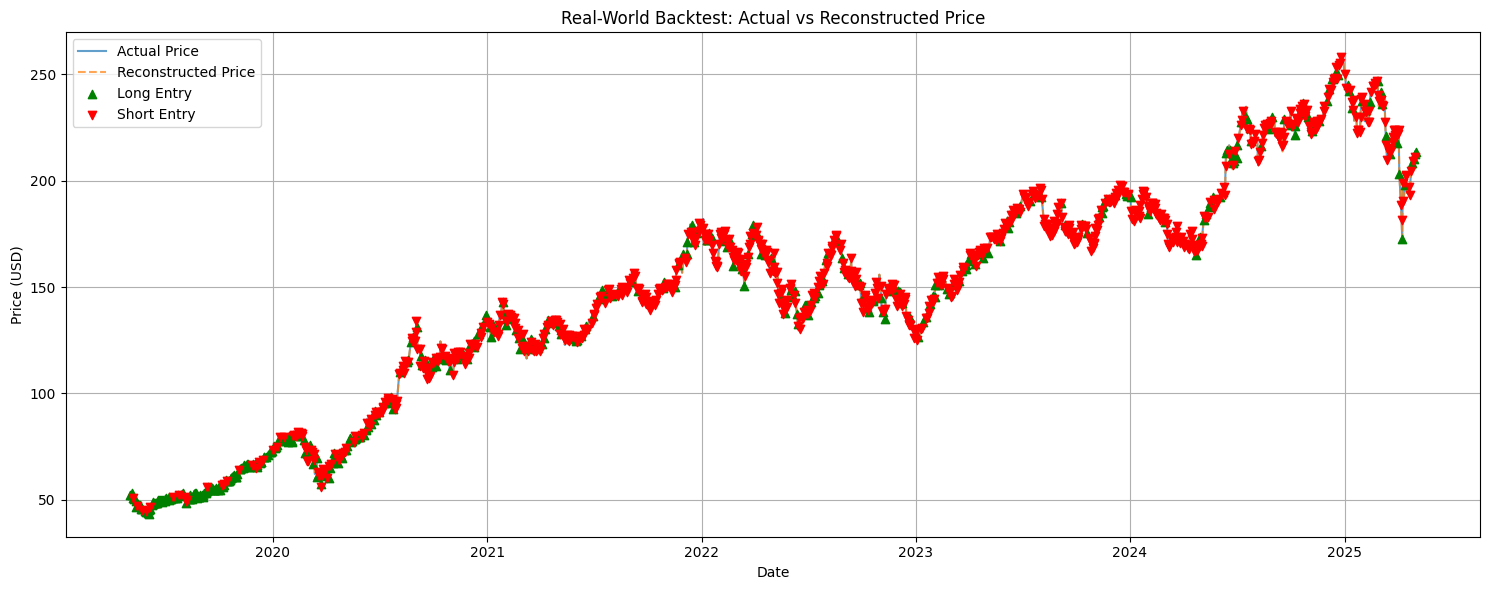

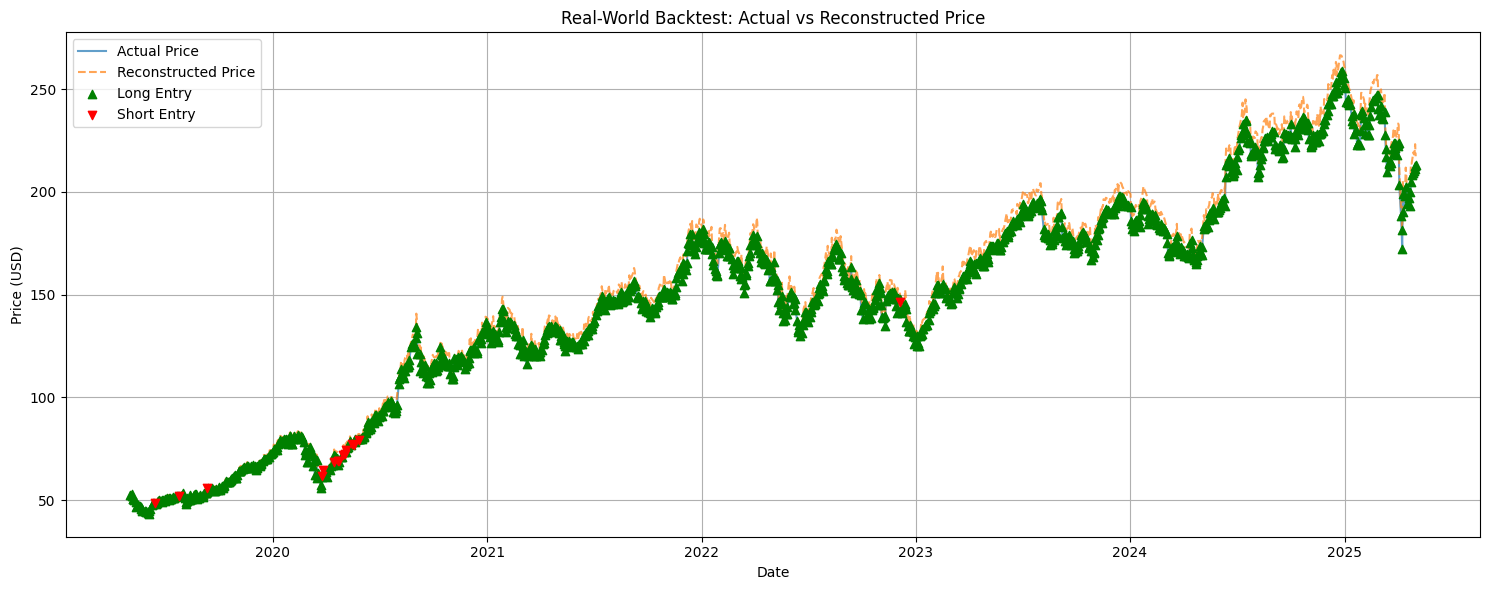

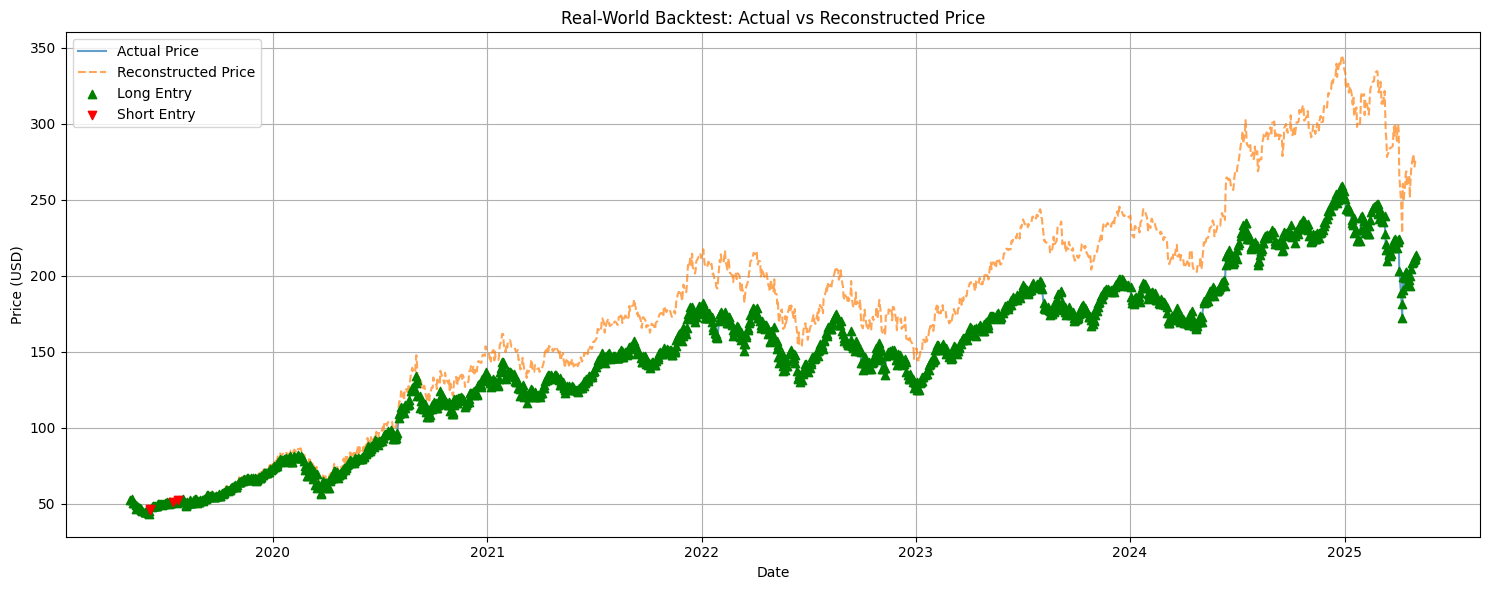

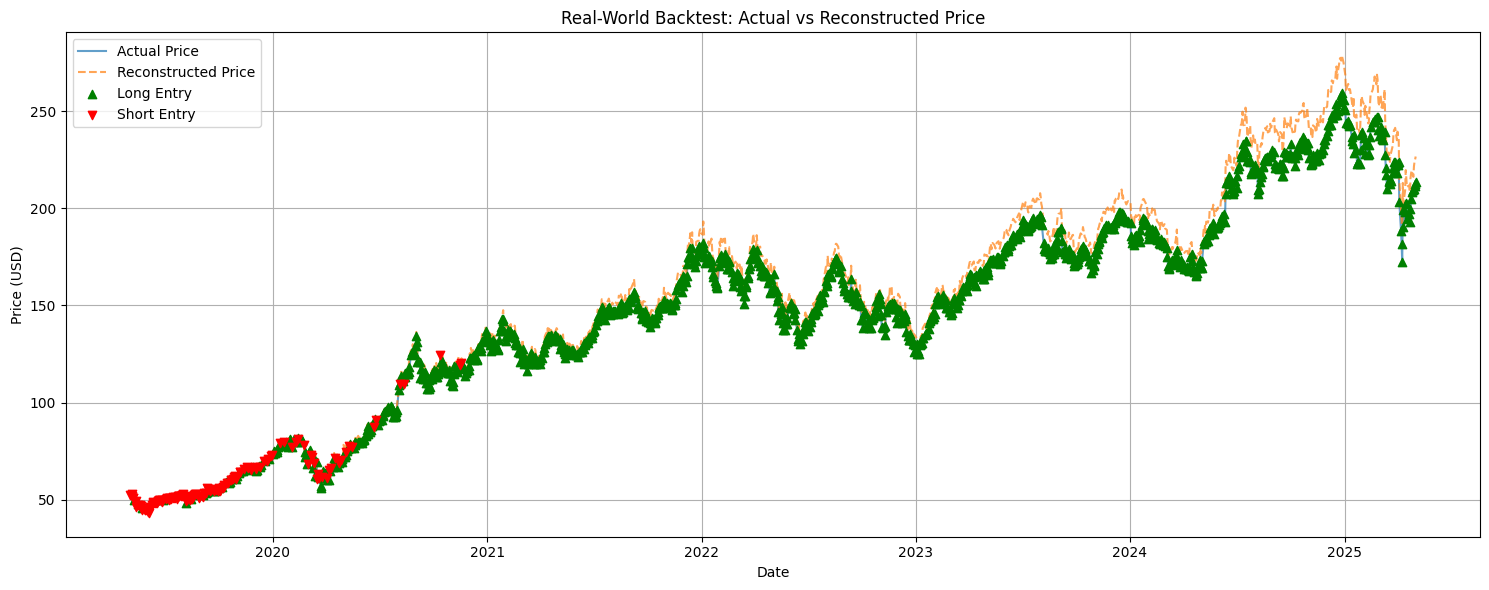

In [9]:
features = [
    "Open", "High", "Low", "Close", "Volume",
    "LogReturn_Lag1", "LogReturn_Lag2", "LogReturn_Lag3",
    "LogReturn_Lag4", "LogReturn_Lag5"
]

base_config_template = {
    "csv_path": "stocks/AAPL.csv",
    "features": features,
    "target": "LogReturn",
    "loader_func": load_data_with_logReturn
}

mlp_extra_config = {
    "config": {
        "window": 50,
        "stride": 50,
        "batch_size": 64,
        "shuffle_train_set": False,
        "lr": 1e-3,
        "epochs": 20,
        "dropout_rate": 0.2,
        "device": device
    }
}

sim_config = {
    "csv_path": base_config_template["csv_path"],
    "features": base_config_template["features"],
    "target": base_config_template["target"],
    "sim_start_date": "2019-05-01",
    "sim_end_date": "2025-05-01",
    "loader_func": base_config_template["loader_func"],
    "window": 50,
    "stride": 1,
    "batch_size": 64,
    "device": device
}

slide_start_dates = pd.date_range("1990-01-01", "2005-01-01", freq="5YS").strftime("%Y-%m-%d").tolist()

for start in slide_start_dates:
    start_year = int(start[:4])
    end_year = start_year + 15
    end = f"{end_year}-04-30" 

    print(f"[INFO] Running experiment from {start} to {end}...")

    base_config = {
        **base_config_template,
        "train_val_test_start": start,
        "train_val_test_end": end,
    }

    mlp_config = {**base_config, **mlp_extra_config}

    runner = BacktestRunner(MLP_Regression, mlp_config)
    runner.train_optimal_model()
    runner.evaluate_model()
    runner.run_real_world_simulation(MLP_Simulation, sim_config)
    runner.log_results(log_name=f"{start}_to_{end}")

In [5]:
from torchinfo import summary
summary(runner.model.model, input_size=(64, 500))


Layer (type:depth-idx)                   Output Shape              Param #
MLPNet                                   [64, 1]                   --
├─Sequential: 1-1                        [64, 1]                   --
│    └─Linear: 2-1                       [64, 256]                 128,256
│    └─ReLU: 2-2                         [64, 256]                 --
│    └─Dropout: 2-3                      [64, 256]                 --
│    └─Linear: 2-4                       [64, 128]                 32,896
│    └─ReLU: 2-5                         [64, 128]                 --
│    └─Dropout: 2-6                      [64, 128]                 --
│    └─Linear: 2-7                       [64, 64]                  8,256
│    └─ReLU: 2-8                         [64, 64]                  --
│    └─Dropout: 2-9                      [64, 64]                  --
│    └─Linear: 2-10                      [64, 32]                  2,080
│    └─ReLU: 2-11                        [64, 32]                  --
